In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix


%matplotlib inline

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
def plot_roc_auc(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

In [4]:
def build_model(model, X_train, X_test, y_train, y_test):
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    f_score = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.argmax(f_score)

    plot_roc_auc(y_test, y_pred)

    return {'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f_score[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std}

In [5]:
#Загружаем данные
df = pd.read_csv('train_case2.csv', ';')
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [6]:
#Делим на трейн/тест
X = df.drop(columns=['cardio'])
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
#Создаем пайплайн для трансформации данных
cont_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

cont_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in cont_cols:
    transfomer =  Pipeline([
                ('Selector', NumberSelector(key=cont_col)),
                ('Scaler', StandardScaler())
            ])
    cont_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('Selector', ColumnSelector(key=cat_col)),
                ('OHE', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('Selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

# Объединяем в единый пайплайн
feats = FeatureUnion(cont_transformers+cat_transformers+base_transformers)

### 1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
### 2. При обучении моделей обязательно использовать кроссвалидацию
### 3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [8]:
#Датафрейм с метриками
metrics = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std'])

In [9]:
#Логистическая регрессия
clf_logreg = Pipeline([
    ('Features', feats),
    ('Classifier', LogisticRegression(random_state=42)),
])

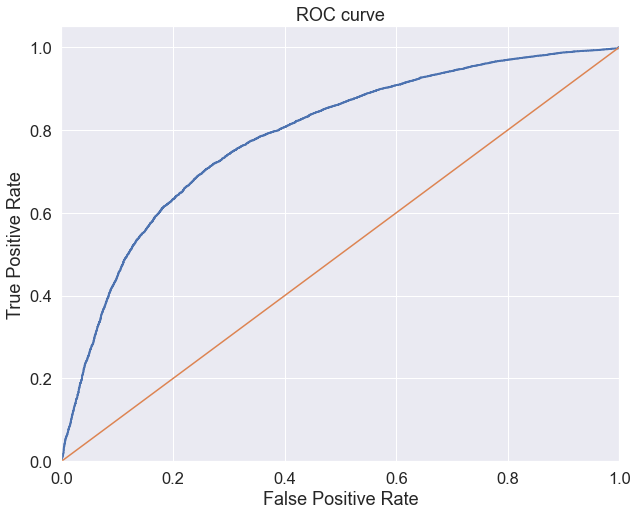

In [10]:
metrics_logreg = build_model(clf_logreg, X_train, X_test, y_train, y_test)
metrics = metrics.append(metrics_logreg, ignore_index=True)

In [11]:
#Случайный лес
clf_rf = Pipeline([
    ('Features', feats),
    ('Classifier', RandomForestClassifier(random_state=42)),
])

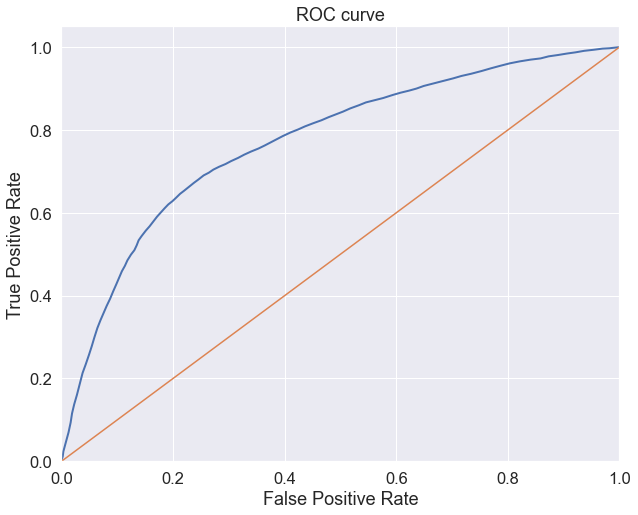

In [12]:
metrics_rf = build_model(clf_rf, X_train, X_test, y_train, y_test)
metrics = metrics.append(metrics_rf, ignore_index=True)

In [13]:
#Градиентный бустинг
clf_gb = Pipeline([
    ('Features', feats),
    ('Classifier', GradientBoostingClassifier(random_state=42)),
])

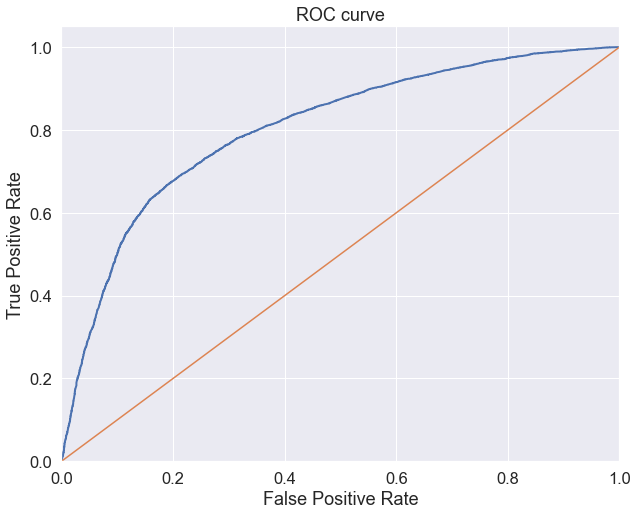

In [14]:
metrics_gb = build_model(clf_gb, X_train, X_test, y_train, y_test)
metrics = metrics.append(metrics_gb, ignore_index=True)

In [15]:
metrics

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std
0,0.655534,0.837494,0.735426,0.785239,0.782094,0.003214
1,0.652684,0.808670,0.722352,0.772244,0.774787,0.002694
2,0.715684,0.779846,0.746389,0.803264,0.801833,0.004118


### 4. Сделать выводы о том, какая модель справилась с задачей лучше других.

По всем метрикам, кроме Recall, градиентный бустинг справился с выявлением закономерностей в датасете лучше всех и оказался наиболее точен.

Если бы было решено, что Recall важнее чем Precision, то лучше воспользоваться логистической регрессией, если важен Precision, то градиентным бустингом.